## Arbeitsschritte

Was ich erwarte:
* Daten laden ###
* Erste “Insights”, d.h. explorative Datenanalayse inkl. einiger Charts (Verteilungen, erste Korrelationen etc.,) um die Daten zu verstehen ###
* Datacleaning ###
* Feature Engineering ###
* Modellbildung
* alle klassischen Modelle, die Sie bisher kennen
* XGBoost ###
* Neuronales Netz ###
* Für die besten Modelle: Hyperparameter Tuning (GridSearchCV) ###
* ggf. auch Mischung verschiedener Modelle (Ensemble) ###
* Feature Importance / Permutation Importance ###
* Eine Submission soll für die test.csv erstellt werden und bei Kaggle hochgeladen werden
* Am Ende zwei reißerische Grafiken mit jeweils einer Einsicht auf Basis der KI-Modelle (storytelling beachten!)
* Für jedes Kapitel eine kurze (gerne stichwortartige) Zusammenfassung im Notebook, was gemacht bzw. was noch so versucht wurde, jedoch nicht geklappt hat und welche Erkentnisse im Kapitel gesammelt wurden.


Organisatorisches:

* Abgabe
* Form eines Git-Links zu Ihrem Projekt
* Montag 08.04.. , 23:59 Uhr
* Sie haben in meinem Unterricht zwei Termine Zeit für diesen Teil (12.02. und 19.02.)

# Mies viele Kommentare

# One Hot Encoden ??? markdownzelle mit begründung warum nicht verwendet

# auf rmspe score bei ML umstellen

# in best p.py grobe idee erklären und ablauf

# device wahl für torch automatisch

# bei prediction mit NN prediction mit e^x verrechnen wegen log(sales)

# Daten Laden und zusammenführen

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from best_params import make # importiert die Funktion make aus der Datei best_params.py um die besten Parameter für die ML-Verfahren zu finden
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn
import json
from sklearn.metrics import r2_score
import seaborn as sns
import xgboost
import numpy as np

df = pd.read_csv("train.csv")
store_df = pd.read_csv("store.csv")

# Zusatzinformation der einzelnen Geschäfte in den Haupt DataFrame laden
big_df = df.merge(store_df, on="Store", how="left")
store_df

C:\Users\pasca\AppData\Local\Temp\ipykernel_3620\2084031152.py:23: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("train.csv")


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## EDA

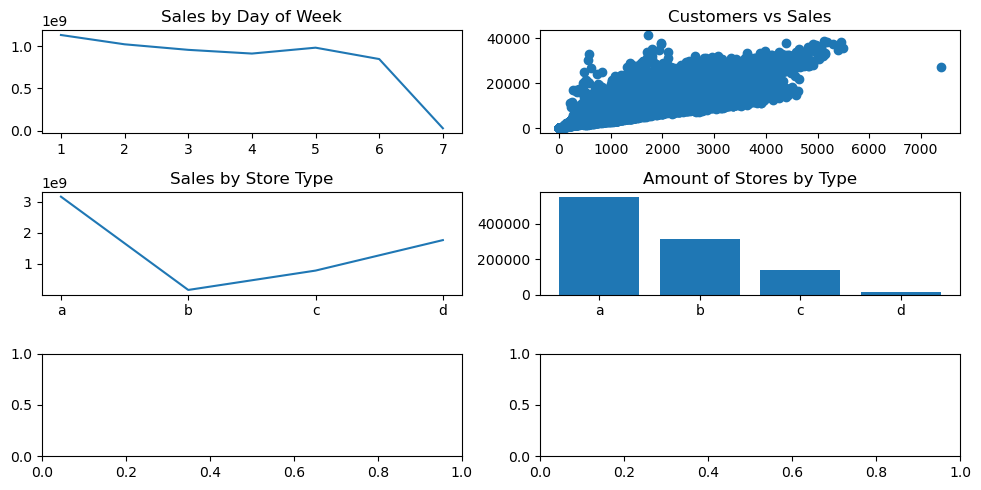

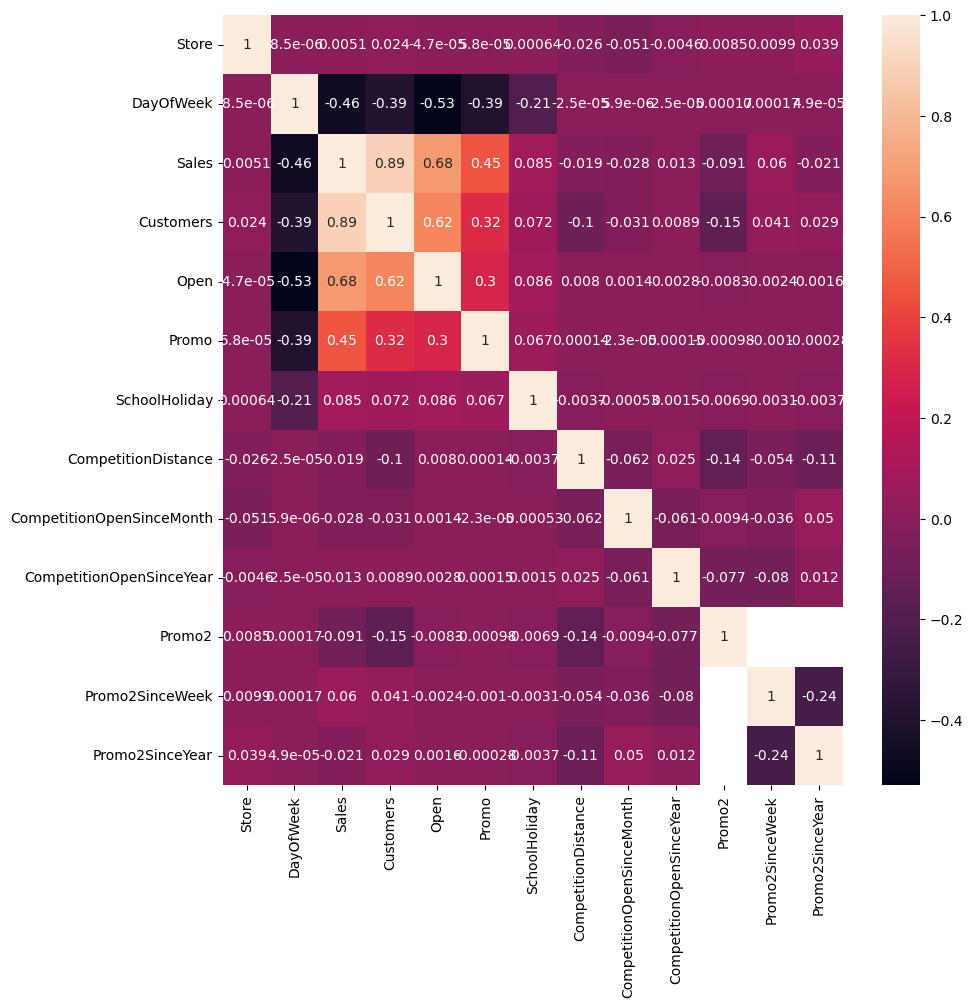

In [50]:
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Plot 1: Sales by Day of WeekVerkäufe nach Wochentag 
s_b_d = big_df["Sales"].groupby(big_df["DayOfWeek"]).sum()
axs[0, 0].plot(s_b_d)
axs[0, 0].set_title('Sales by Day of Week')

# Plot 2: Punktwolke mit Vergleich zwischen Customers und Sales 
axs[0, 1].scatter(big_df["Customers"], big_df["Sales"])
axs[0, 1].set_title('Customers vs Sales')

# Plot 3: Verkäufe nach Geschäftsart 
sales_by_storeType = big_df["Sales"].groupby(big_df["StoreType"]).sum()
axs[1, 0].plot(sales_by_storeType)
axs[1, 0].set_title('Sales by Store Type')

# Plot 4: Anzahl der Geschäfte nach Typ 
amt_stores_by_type = big_df["StoreType"].value_counts()
axs[1, 1].bar(["a", "b", "c", "d"], amt_stores_by_type)
axs[1, 1].set_title('Amount of Stores by Type')

# Durchschnittliche Käufe pro Kunde
#sales_per_customer = big_df["Sales"] / big_df["Customers"]
#big_df["sales_per_customer"] = sales_per_customer

# Durchschnittliche Käufe pro Kunde nach Store Type
#m_sales_customer_by_st = big_df["sales_per_customer"].groupby(big_df["StoreType"]).sum().values.tolist()
#axs[2, 0].plot(big_df["StoreType"].unique(), m_sales_customer_by_st)
#axs[2, 0].set_title("mean_sales_p_cust_by_stoTyp")

# Grafiken ausgeben
plt.tight_layout()
plt.show()

# 
numeric_cols = big_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.show()

## Datacleaning

In [51]:
def apply_cleaning(df):
    # Leere Werte der Spalte Competition Distance mit 0 füllen
    df["CompetitionDistance"] = df["CompetitionDistance"].fillna(-1)
    # 
    comp_zeros = df["CompetitionDistance"] == -1
    df["CompetitionOpenSinceMonth"][comp_zeros] = -1
    df["CompetitionOpenSinceYear"][comp_zeros] = -1
    df = df.dropna(axis=0)
    return df

# Die Bereinigung auf den Haupt DataFrame anwenden 
big_df = apply_cleaning(big_df)
big_df.head(5)

C:\Users\pasca\AppData\Local\Temp\ipykernel_3620\1701533950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceMonth"][comp_zeros] = -1
C:\Users\pasca\AppData\Local\Temp\ipykernel_3620\1701533950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceYear"][comp_zeros] = -1


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
13,14,5,2015-07-31,6544,710,1,1,0,1,a,a,1300.0,3.0,2014.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
14,15,5,2015-07-31,9191,766,1,1,0,1,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [52]:
# 
big_df["Date"].unique()

array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

## Feature Engineering

In [53]:
def do_fe(df, test=False):
    
    #
    to_drop = ["Date", "Store"]
    df["year"] = df["Date"].str.split("-").str[0]
    df["month"] = df["Date"].str.split("-").str[1]
    df["year"] = df["year"].astype(int) - 2013
    df["month"] = df["month"].astype(int) - 1
    
    df = df.drop(to_drop, axis=1)

    #
    df["CompetitionDistance"] = df["CompetitionDistance"].astype(int)
    df["CompetitionOpenSinceMonth"] = df["CompetitionOpenSinceMonth"].astype(int)
    df["CompetitionOpenSinceYear"] = df["CompetitionOpenSinceYear"].astype(int)
    df["Promo2SinceWeek"] = df["Promo2SinceWeek"].astype(int)
    df["Promo2SinceYear"] = df["Promo2SinceYear"].astype(int)

    # 
    #big_df["promo2week_bool"] = big_df["Promo2SinceWeek"].isna()

    # Die Storytypen und Sortimentenart in eine numerischen Skalierung überführen 
    store_type_dict = {"a": 0, "b": 1, "c": 2, "d": 3}
    df["StoreType"] = df["StoreType"].map(store_type_dict)
    assortment_dict = {"a": 0, "b": 1, "c": 2}
    df["Assortment"] = df["Assortment"].map(assortment_dict)

    # Die Spalte Promo Intervall enthält 3 Unique Werte. 
    # Um zu verhindern, Das eine Wertigkeit erlernt wird, haben wir uns dazu entschieden Für jeden Monat eine Spalte anzulegen.
    # Alle Spalten werden bei Erstellung mit Nullen gefüllt. Dann wird über die Elemente der Spalte PromoIntervall itteriert und je nach einem der 3 Fälle, 
    # die entsprechenden Zellen der entsprechenden Spalten mit Einsen gefüllt (Beim Januar also die Zellen der Spalten Januar April, Juli und Oktober).
    df["jan"] = 0
    df["feb"] = 0
    df["mar"] = 0
    df["apr"] = 0
    df["may"] = 0
    df["jun"] = 0
    df["jul"] = 0
    df["aug"] = 0
    df["sep"] = 0
    df["oct"] = 0
    df["nov"] = 0
    df["dec"] = 0

    for index, row in df.iterrows():
        start = row["PromoInterval"].split(",")[0]
        match start:
            case "Jan":
                df.at[index, "jan"] = 1
                df.at[index, "apr"] = 1
                df.at[index, "jul"] = 1
                df.at[index, "oct"] = 1

            case "Feb":
                df.at[index, "feb"] = 1
                df.at[index, "may"] = 1
                df.at[index, "aug"] = 1
                df.at[index, "nov"] = 1

            case "Mar":
                df.at[index, "mar"] = 1
                df.at[index, "jun"] = 1
                df.at[index, "sep"] = 1
                df.at[index, "dec"] = 1

    df = df.drop("PromoInterval", axis=1)   

    # Alle Spaltentitel in lower Snake Case umwandeln
    for col in df.columns:
        col_n = re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower()
        df.rename(columns={col: col_n}, inplace=True)

    # !!!!!!! mit wertigkeit weil weihnachten für shoppen wichtiger als kein urlaub
    holiday_map = {"0": 0, "a": 1, "b": 2, "c": 3, 0: 0}
    df["state_holiday"] = df["state_holiday"].map(holiday_map)

    
    # Da in diesen Spalten im Vergleich zu den anderen des DataFrames sehr hohe Werte vorkommen, haben wir uns dazu entschlossen, den natürlichen Logarithmus der jeweiligen Spalte zu ziehen, damit die Modelle vernünftig lernen können
    try:
        df["sales"] = np.log(df["sales"])
    except:
        pass
    try:
        #df["customers"] = np.log(df["customers"])
        df = df.drop("customers", axis=1)
    except:
        pass
    df["competition_distance"] = np.log(df["competition_distance"])

    return df

big_df = do_fe(big_df)
big_df

c:\Users\pasca\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\pasca\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,day_of_week,sales,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
1,5,8.710125,1,1,0,1,0,0,6.345636,11,...,0,1,0,0,1,0,0,1,0,0
2,5,9.025696,1,1,0,1,0,0,9.556055,12,...,0,1,0,0,1,0,0,1,0,0
10,5,9.255027,1,1,0,1,0,2,6.866933,11,...,0,1,0,0,1,0,0,1,0,0
13,5,8.786304,1,1,0,1,0,0,7.170120,3,...,0,1,0,0,1,0,0,1,0,0
14,5,9.125980,1,1,0,1,3,2,8.321178,3,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017198,2,-inf,0,0,1,1,2,2,5.799093,11,...,0,0,1,0,0,1,0,0,1,0
1017199,2,-inf,0,0,1,1,0,2,8.581107,9,...,0,1,0,0,1,0,0,1,0,0
1017200,2,-inf,0,0,1,1,0,0,7.244228,6,...,0,1,0,0,1,0,0,1,0,0
1017202,2,-inf,0,0,1,1,2,0,8.157657,4,...,0,1,0,0,1,0,0,1,0,0


In [54]:
#print(big_df["PromoInterval"].unique()) # im 3-Monats Intervall
big_df.columns

Index(['day_of_week', 'sales', 'open', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'jan', 'feb',
       'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
      dtype='object')

# Modellbildung

In [55]:
# 
X = big_df.drop("sales", axis=1)
y = big_df["sales"]

X.replace([np.inf, -np.inf], np.nan, inplace=True)
# 
X.fillna(0, inplace=True)

y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.fillna(0, inplace=True)

#
scaler=StandardScaler()
scaler.fit(X)
x_scaled=scaler.transform(X)

x_scaled_df = pd.DataFrame(x_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size=0.2, random_state=42, shuffle=True)

# Die Funktion make kann aufgerufen werden, um die optimalen Parameter für die Machine Learning-Verfahren zu errechnen und in eine json-Datei zu speichern
# print("MAKE IS STARTING")
# make(X_train, y_train)
# print("MAKE IS DONE")

In [56]:
# Die besten Parameter aus der json-Datei laden
params_f = json.load(open("best_params.json", "r"))

def make_voting(X_train, y_train, X_test, y_test):
    # Das jeweilige Dictionary mit dem Parametern für das jeweilige Verfahren herausnehmen
    best_knn_params = params_f["knn"]
    best_tree_params = params_f["tree"]
    best_forest_params = params_f["forest"]
    #best_svm_params = params_f["svm"]
    #best_lin_reg_params = params_f["lin_reg"]
    best_xg_params = params_f["xg"]
    best_adaboost_params = params_f["adaboost"]
    best_gradientboost_params = params_f["gradientboost"]

    # Je Parameter Dictionary ein Vorhersagemodell aus diesen Daten bauen
    knn = KNeighborsRegressor(n_neighbors=best_knn_params["kneighborsregressor__n_neighbors"],
                             weights=best_knn_params["kneighborsregressor__weights"],
                             algorithm=best_knn_params["kneighborsregressor__algorithm"])
    tree = DecisionTreeRegressor(max_depth=best_tree_params["decisiontreeregressor__max_depth"],
                                 min_samples_split=best_tree_params["decisiontreeregressor__min_samples_split"],
                                 min_samples_leaf=best_tree_params["decisiontreeregressor__min_samples_leaf"])
    forest = RandomForestRegressor(n_estimators=best_forest_params["randomforestregressor__n_estimators"],
                                   max_depth=best_forest_params["randomforestregressor__max_depth"],
                                   min_samples_split=best_forest_params["randomforestregressor__min_samples_split"],
                                   min_samples_leaf=best_forest_params["randomforestregressor__min_samples_leaf"])
    #svm = SVR(kernel=best_svm_params["svr__kernel"],
    #        degree=best_svm_params["svr__degree"],
    #        C=best_svm_params["svr__C"])
    #lin_reg = LinearRegression(fit_intercept=best_lin_reg_params["linearregression__fit_intercept"])
    xg = xgboost.XGBRegressor(learning_rate=best_xg_params["xgbregressor__learning_rate"],
                            max_depth=best_xg_params["xgbregressor__max_depth"],
                            n_estimators=best_xg_params["xgbregressor__n_estimators"])
    adaboost = AdaBoostRegressor(n_estimators=best_adaboost_params["adaboostregressor__n_estimators"],
                             learning_rate=best_adaboost_params["adaboostregressor__learning_rate"])
    gradientboost = GradientBoostingRegressor(n_estimators=best_gradientboost_params["gradientboostingregressor__n_estimators"],
                                          learning_rate=best_gradientboost_params["gradientboostingregressor__learning_rate"],
                                          max_depth=best_gradientboost_params["gradientboostingregressor__max_depth"])

    
    # Die Testdaten laden und auf dieselbe Weise transformieren wie die Trainingsdaten (Bereinigung und Feature Engineering)
    test_df = pd.read_csv("test.csv")
    test_df = test_df.merge(store_df, on="Store", how="left")
    print("1111")
    test_df = apply_cleaning(test_df)
    print("1111")
    test_df = do_fe(test_df, test=True)

    ids = [i for i in range(len(test_df["id"]))]

    test_df = test_df.drop("id", axis=1)
    test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# 
    test_df.fillna(0, inplace=True)

    print("1111")

    # Die Machine Learning Modelle auf die Daten trainieren und ihren r2-Score ausgeben
    knn.fit(X_train, y_train)
    print("knn done")
    print(mean_squared_error(y_test, knn.predict(X_test)))
    knn_pred = knn.predict(test_df)
    knn_df = pd.DataFrame({"Id": ids, "Sales": knn_pred})
    knn_df.to_csv("knn.csv", index=False)
    del knn_df

    print("2222")

    tree.fit(X_train, y_train)
    print("tree done")
    print(mean_squared_error(y_test, tree.predict(X_test)))
    tree_pred = tree.predict(test_df)
    tree_df = pd.DataFrame({"Id": ids, "Sales": tree_pred})
    tree_df.to_csv("tree.csv", index=False)
    del tree_df

    forest.fit(X_train, y_train)
    print("forest done")
    print(mean_squared_error(y_test, forest.predict(X_test)))
    forest_pred = forest.predict(test_df)
    forest_df = pd.DataFrame({"Id": ids, "Sales": forest_pred})
    forest_df.to_csv("forest.csv", index=False)
    del forest_df

    # svm.fit(X_train, y_train)
    # print("svm done")
    # print(mean_squared_error(y_test, svm.predict(X_test)))
    # svm_pred = svm.predict(test_df)
    # svm_df = pd.DataFrame({"Id": ids, "Sales": svm_pred})
    # svm_df.to_csv("svm.csv", index=False)
    # del svm_df

    #lin_reg.fit(X_train, y_train)
    #print("lin_reg done")
    #print(mean_squared_error(y_test, lin_reg.predict(X_test)))
    
    xg.fit(X_train, y_train)
    print("xg done")
    print(mean_squared_error(y_test, xg.predict(X_test)))
    xg_pred = xg.predict(test_df)
    xg_df = pd.DataFrame({"Id": ids, "Sales": xg_pred})
    xg_df.to_csv("xg.csv", index=False)
    del xg_df

    # Trainieren und Vorhersagen mit AdaBoost und GradientBoost
    adaboost.fit(X_train, y_train)
    print("adaboost done")
    print(mean_squared_error(y_test, adaboost.predict(X_test)))
    adaboost_pred = adaboost.predict(test_df)
    adaboost_df = pd.DataFrame({"Id": ids, "Sales": adaboost_pred})
    adaboost_df.to_csv("adaboost.csv", index=False)
    del adaboost_df

    gradientboost.fit(X_train, y_train)
    print("gradientboost done")
    print(mean_squared_error(y_test, gradientboost.predict(X_test)))
    gradientboost_pred = gradientboost.predict(test_df)
    gradientboost_df = pd.DataFrame({"Id": ids, "Sales": gradientboost_pred})
    gradientboost_df.to_csv("gradientboost.csv", index=False)
    del gradientboost_df

    # Einen VotingRegressor aus den am besten performenden Modellen bauen und auf die Daten trainieren
    voting = VotingRegressor(estimators=[("knn", knn), ("tree", tree), ("forest", forest), ("xg", xg), ("adaboost", adaboost), ("gradientboost", gradientboost)]) #SVM raus & n_jobs= Anzahl Kerne CPU
    voting.fit(X_train, y_train)
    print("voting done")

    # Den Mean Squared Error und die Genauigkeit des Votings ausgeben
    error = mean_squared_error(y_test, voting.predict(X_test))
    print("ERROR:", error)
    #accuracy = voting.score(y_test, voting.predict(X_test))
    #print("Accuracy:", accuracy)

    # Die Feature importance vom Voting errechnen und anzeigen
    # feature_importance = voting.feature_importances_
    # plt.barh(X_train.columns, feature_importance)
    # plt.show()

    # Mit jedem Machine Learning Modell aus den Testdaten vorhersagen erstellen
    
    voting_pred = voting.predict(test_df)

    # 
    
    v_df = pd.DataFrame({"Id": ids, "Sales": voting_pred})
    v_df.to_csv("voting.csv", index=False)
    del v_df
    
    return voting

vot = make_voting(X_train, y_train, X_test, y_test) # error: accuracy = voting.score(y_test, voting.predict(X_test)) -> Expected 2D array, got 1D array instead

1111
1111


C:\Users\pasca\AppData\Local\Temp\ipykernel_3620\1701533950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceMonth"][comp_zeros] = -1
C:\Users\pasca\AppData\Local\Temp\ipykernel_3620\1701533950.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompetitionOpenSinceYear"][comp_zeros] = -1
c:\Users\pasca\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1111
knn done
0.034065337972221305
2222
tree done
0.023804481996421108
forest done
0.023512575304040637
xg done
0.02240313620950979
adaboost done
0.11104853693006578
gradientboost done
0.01815267122239309
voting done
ERROR: 0.023019427386895795


In [57]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1_h = 500
        self.l2_h = 500
        self.l3_h = 200
        self.l4_h = 1

        # Für Linear-Layer entschieden, da es in diesem Fall um Zusammenhänge je Zeile geht
        self.l1 = nn.Linear(X.shape[1], self.l1_h)
        self.l2 = nn.Linear(self.l1_h, self.l2_h)
        self.l3 = nn.Linear(self.l2_h, self.l3_h)
        self.l4 = nn.Linear(self.l3_h, self.l4_h)

        self.relu = nn.ReLU()

        # Batch Normalisierung nach jeder Layer, um extrem große Werte zu verhindern  
        self.b1 = nn.BatchNorm1d(self.l1_h)
        self.b2 = nn.BatchNorm1d(self.l2_h)
        self.b3 = nn.BatchNorm1d(self.l3_h)
        self.b4 = nn.BatchNorm1d(self.l4_h)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.b1(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.b2(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.b3(x)
        x = self.l4(x)
        x = self.relu(x)
        x = self.b4(x)
        return x
        
# 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
# 
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, x):
        self.x = torch.tensor(x.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

# Manuel Seed gesetzt, damit die Ergebnisse der verschiedenen Durchläufe des neuronalen Netzes besser vergleichbar werden 
torch.manual_seed(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

# 
model = Model()
model.to(device)
optmizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_fn = nn.MSELoss()
dataset = Dataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
#schedular = torch.optim.lr_scheduler.CosineAnnealingLR(optmizer, T_max=20)
test_loader = torch.utils.data.DataLoader(Dataset(X_test, y_test), batch_size=256, shuffle=True)

epochs = 60
losses = []
test_losses = []

# 
for epoch in range(epochs):
   for xb, yb in data_loader:
       xb, yb = xb.to(device), yb.to(device)
       y_hat = model(xb)
       loss = loss_fn(y_hat, yb)
       loss.backward()
       optmizer.step()
       optmizer.zero_grad()
       #schedular.step()
   print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")
   losses.append(loss.item())
   with torch.no_grad():
        for xb, yb in test_loader:
              xb = xb.to(device)
              y_hat = model(xb)
              test_loss = loss_fn(y_hat, yb)
        test_losses.append(test_loss.item())

# Einen Zwischenstand des Modells mit den errechneten Gewichten abspeichern
torch.save(model.state_dict(), "model_XXX.pt")

# Die beiden Listen Train- und Testloss als Grafen mit beschrifteten Achsen ausgeben 
plt.plot(losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Bei aktuellen Einstellungen verringert sich Der Loss des Modells über 60 Epochen auf ungefähr 0,1. Dabei weichen Train und Testlos kaum voneinander ab

Using:  cpu


c:\Users\pasca\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pasca\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\pasca\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.ms

Epoch [1/60], Loss: 57.692588806152344


c:\Users\pasca\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([249])) that is different to the input size (torch.Size([249, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/60], Loss: 53.02131652832031
Epoch [3/60], Loss: 49.457069396972656
Epoch [4/60], Loss: 51.57039260864258
Epoch [5/60], Loss: 50.01099395751953
Epoch [6/60], Loss: 46.3852424621582
Epoch [7/60], Loss: 43.403350830078125
Epoch [8/60], Loss: 42.058319091796875
Epoch [9/60], Loss: 38.94025802612305
Epoch [10/60], Loss: 40.7234992980957
Epoch [11/60], Loss: 36.211795806884766
Epoch [12/60], Loss: 32.876834869384766
Epoch [13/60], Loss: 31.97710609436035
Epoch [14/60], Loss: 29.04522132873535


In [ ]:
# 
nn_res = []
final_test_df = pd.read_csv("test.csv")
final_test_df = apply_cleaning(final_test_df)
final_test_df = do_fe(final_test_df)
final_test_dataset = TestDataset(final_test_df)

# Das Modell mit den Gewichten aus dem Zwischenstand laden
model = Model()
model.load_state_dict(torch.load("model_small_60E_loss0point2.pt"))

# Die Vorhersagen des Modells auf die Testdaten erstellen
for xb in final_test_dataset:
    y_hat = model(xb)
    nn_res.append(y_hat.item())

# 
nn_df = pd.DataFrame({"Id": [i for i in range(len(final_test_df["id"]))], "Sales": nn_res})
nn_df.to_csv("nn.csv", index=False)

# Grafiken erstellen

In [ ]:
# Vorläufige Ideen für Grafiken:
#   - An welchem Wochentag je intervall wie viel gekauft wurde
#   - An welchem Wochentag je StoreType wie viel gekauft wurde
#   - vorhersage von sales
#   - vorhersage von sales per customer
#   - monatliche summierte verkaufszahlen in den Jahren 2013 und 2014, 2015 solange noch daten da sind (07), ab 08 vorhersagen, Monate mit Promo-Intervall hinterlegen mit Box
#   - Punktwolke: x-Achse: Entfernungen min bis max., y-Achse: Verkäufe jedes Shops, farblich unterschieden nach Storetype

In [ ]:
# Plot 1: die monatlichen Verkaufszahlen der Jahre 2013, 2014 und teilweise 2015 (restliche Werte für 2015 werden mit dem Neuronalen Netz und den Daten der test.csv errechnet). Die Monate, in denen ein Promo-Intervall stattfand, sind farblich hervorgehoben
nums13 = df["Sales"][df["year"] == "2013"].groupby(df["month"]).sum().values
nums14 = df["Sales"][df["year"] == "2014"].groupby(df["month"]).sum().values
nums15 = df["Sales"][df["year"] == "2015"].groupby(df["month"]).sum().values

x_elems = [i for i in range(1, 13)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x_elems, nums13, label="2013")
ax.bar(x_elems, nums14, label="2014")
ax.bar(x_elems, nums15, label="2015")
ax.legend()
plt.show()

In [ ]:
# Plot 2: Scatter-plot mit Entfernungen der Konkurrenzgeschäfte auf der X-Achse und den Verkäufen der jeweiligen Geschäfte auf der Y-Achse. Die Punkte sind farblich nach StoreType unterschieden
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(big_df["competition_distance"], big_df["sales"], c=big_df["store_type"])
plt.show()